# Penndulum Model Codes

## Dependencies

In [182]:
import os
import shutil
import random; random.seed(42)

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn
from reservoirpy import mat_gen, ESN

## Directories:

In [183]:
# training data
train_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/train'
train_dir_video = '/raid/cs152/zxaa2018/penndulum//train_and_test_split/dpc_dataset_traintest_4_200_h264/train'

# test data
test_inputs_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/test_inputs/'
test_targets_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/test_targets/'
test_targets_video = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_h264/test_targets/'

# validation data
validation_inputs_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/validation_inputs/'
validation_targets_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/validation_targets/'
validation_targets_video = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_h264/validation_targets/'

## Functions and Class Definitions

### Data Transformation Functions

In [184]:
# some constants
DEFAULT_X_RED, DEFAULT_Y_RED = (240, 232)

PIXEL_DISTANCE_GREEN_TO_RED = 118 # approx. value | calculated with the Pythagorean theorem and averaged: np.sqrt((y_green-y_red)**2 + (x_green-x_red)**2)
PIXEL_DISTANCE_BLUE_TO_GREEN = 90 # approx. value | calculated with the Pythagorean theorem and averaged: np.sqrt((y_blue-y_green)**2 + (x_blue-x_green)**2)

def raw_to_pixel(l):
    '''Convert the raw coordinates to pixel coordinates.'''
    assert isinstance(l, list)
    return [x/5 for x in l]


def pixel_to_raw(l):
    '''Convert the pixel coordinates to raw coordinates.'''
    assert isinstance(l, list)
    return [x*5 for x in l]


def raw_cartesian_to_polar_angles(l):
    '''Convert the cartesian coordinates to polar coordinates.'''
    assert isinstance(l, list)
    x_red, y_red, x_green, y_green, x_blue, y_blue = raw_to_pixel(l)

    angle_green_red = np.arctan((y_green-y_red)/(x_green-x_red+0.001))
    angle_blue_green = np.arctan((y_blue-y_green)/(x_blue-x_green+0.001))
    
    return [np.sin(angle_green_red), np.cos(angle_green_red), np.sin(angle_blue_green), np.cos(angle_blue_green)]

def polar_angles_to_raw_cartesian(l):
    '''Convert the polar coordinates back to cartesian coordinates.'''
    assert isinstance(l, list)
    sin_angle_green_red, cos_angle_green_red, sin_angle_blue_green, cos_angle_blue_green = l
    
    y_green = PIXEL_DISTANCE_GREEN_TO_RED * sin_angle_green_red + DEFAULT_Y_RED
    x_green = PIXEL_DISTANCE_GREEN_TO_RED * cos_angle_green_red + DEFAULT_X_RED

    y_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * sin_angle_blue_green + y_green
    x_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * cos_angle_blue_green + x_green
    
    return pixel_to_raw([DEFAULT_X_RED, DEFAULT_Y_RED, x_green, y_green, x_blue, y_blue])

### Data reading functions

Parsing training data:
training data x-y matching is like this:
x: a list of 4 frames
y: the frame that follows

In [185]:
def parse_csv_esn(csv_file):
    '''Given a csv file and a length of sequence, return the sequence in list of list'''
    X_data = []
    f = pd.read_csv(csv_file, header=None, delim_whitespace=True, engine='python')
    temp = []
    for i, row in f.iterrows():
        next_frame = row.to_list()
        X_data.append(next_frame.copy())
        
    return X_data

In [186]:
def get_seq_list(source_dir):
    result = []
    name = []
    for filename in tqdm([x for x in os.listdir(source_dir) if not x.startswith('.')]):
        # load in a file
        name.append(filename)
        X_data = parse_csv_esn(os.path.join(source_dir, filename))
        result.append(X_data)
    return result, name

In [187]:
def normalize_sequence(sequence: np.ndarray):
    '''Given a sequence in shape (n,6), normalize the sequence to [-1,1]'''
    # get range of x coords 0,2,4
    x_factor = (sequence[:,[0,2,4]].max() - sequence[:,[0,2,4]].min()) * 1.0
    y_factor = (sequence[:,[1,3,5]].max() - sequence[:,[1,3,5]].min()) * 1.0

    sequence[:,[0,2,4]] = sequence[:,[0,2,4]] / max(x_factor,1e-6) - 0.5
    sequence[:,[1,3,5]] = sequence[:,[1,3,5]] / max(y_factor, 1e-6) - 0.5

    return sequence, (x_factor, y_factor)

def denormalize_sequence(sequence: np.array, factors: tuple):
    '''Given a sequence in shape (n,6), normalized to [-1,1], and the normalize factors along the x, y axis, return the denormalized sequence'''
    sequence[:,[0,2,4]] = (sequence[:,[0,2,4]] + 0.5) * factors[0]
    sequence[:,[1,3,5]] = (sequence[:,[1,3,5]] + 0.5) * factors[1]

    return sequence
    

### Dataset Definition

In [188]:
class NormalizedDatast():
    def __init__(self,X_list: list, name_list: list):
        self.sample_List = []
        self.factor_list = []
        self.name_dict = {}
        for i, (seq, name) in enumerate(zip(X_list, name_list)):
            self.name_dict[i] = name
            norm_seq, factors = normalize_sequence(np.array(seq, dtype=float))
            self.sample_List.append(norm_seq)
            self.factor_list.append(factors)

    def __len__(self):
        return len(self.sample_list)
    
    def getFactor(self, index: int):
        return self.x_factor_list[index], self.y_factor_list[index]

### Model Definition

Data Visualization Functions

In [189]:
def plot_comparison(Xgen, Xgen_test, length, axis1, axis2):
    t = np.arange(length)
    fig = plt.figure(figsize = (13,5))


    plt.subplot((121))
    plt.title(f"Ground Truth, first {length} frame")
    plt_x = [y[1] for y in Xgen_test[:,[axis1, axis2]][:length]]
    plt_y = [y[0] for y in Xgen_test[:,[axis1, axis2]][:length]]

    plt.plot(plt_x, plt_y, lw=1,color="lightgrey", zorder=0)
    plt.scatter(plt_x, plt_y,lw=0.5, c = t[:len(plt_x)],cmap="viridis", s=6)
    plt.gca().invert_yaxis()
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")

    plt.subplot((122))
    plt.title(f"Prediction, first {length} frame")
    plt_x_res = [y[1] for y in Xgen[:,[axis1, axis2]][:length]]
    plt_y_res = [y[0] for y in Xgen[:,[axis1, axis2]][:length]]

    plt.plot(plt_x_res, plt_y_res, lw=1,color="lightgrey", zorder=0)
    plt.scatter(plt_x_res, plt_y_res,lw=0.5, c = t[:len(plt_x)],cmap="viridis", s=6)
    plt.gca().invert_yaxis()
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")

## Training, testing and analysis Codes

### Loading Training Data

In [190]:
# load in all separate files
Seq_train, Seq_train_name = get_seq_list(train_dir)

Seq_valid_input, Seq_valid_names = get_seq_list(validation_targets_dir)

dataset = NormalizedDatast(Seq_train, Seq_train_name)

valid_dataset = NormalizedDatast(Seq_valid_input,Seq_valid_names)


100%|██████████| 24/24 [00:00<00:00, 56.14it/s]


### Hyperparameter and Model instantiate

In [191]:
units = 1000
leak_rate = 0.2
spectral_radius = 1.0
input_scaling = 1
density = 0.1
input_connectivity = 1.0
regularization = 1e-6
seed = 1234

Win = mat_gen.generate_input_weights(units, 6, input_scaling=input_scaling,
                                     proba=input_connectivity, input_bias=True,
                                     seed=seed)

W = mat_gen.generate_internal_weights(units, sr=spectral_radius,
                              proba=density, seed=seed)

reservoir = ESN(leak_rate, W, Win, ridge=regularization)

### Training

In [192]:
for seq in dataset.sample_List:
    trainlength = seq.shape[0] - 50
    states = reservoir.train([seq[:trainlength]], seq[1: trainlength + 1], verbose=True, return_states=True)   

Training on 1 inputs (6687 steps) -- wash: 0 steps


Train: 100%|██████████| 6687/6687 [00:04<00:00, 1602.46it/s]


Training on 1 inputs (587 steps) -- wash: 0 steps


Train: 100%|██████████| 587/587 [00:00<00:00, 622.25it/s]


Training on 1 inputs (14445 steps) -- wash: 0 steps


Train: 100%|██████████| 14445/14445 [00:08<00:00, 1714.49it/s]


Training on 1 inputs (7436 steps) -- wash: 0 steps


Train: 100%|██████████| 7436/7436 [00:04<00:00, 1623.79it/s]


Training on 1 inputs (4105 steps) -- wash: 0 steps


Train: 100%|██████████| 4105/4105 [00:02<00:00, 1465.65it/s]


Training on 1 inputs (1457 steps) -- wash: 0 steps


Train: 100%|██████████| 1457/1457 [00:01<00:00, 1008.39it/s]


Training on 1 inputs (2345 steps) -- wash: 0 steps


Train: 100%|██████████| 2345/2345 [00:01<00:00, 1174.79it/s]


Training on 1 inputs (11001 steps) -- wash: 0 steps


Train: 100%|██████████| 11001/11001 [00:06<00:00, 1715.36it/s]


Training on 1 inputs (17122 steps) -- wash: 0 steps


Train: 100%|██████████| 17122/17122 [00:10<00:00, 1704.56it/s]


Training on 1 inputs (9284 steps) -- wash: 0 steps


Train: 100%|██████████| 9284/9284 [00:05<00:00, 1670.30it/s]


Training on 1 inputs (606 steps) -- wash: 0 steps


Train: 100%|██████████| 606/606 [00:00<00:00, 627.44it/s]


Training on 1 inputs (4071 steps) -- wash: 0 steps


Train: 100%|██████████| 4071/4071 [00:02<00:00, 1424.75it/s]


Training on 1 inputs (3125 steps) -- wash: 0 steps


Train: 100%|██████████| 3125/3125 [00:02<00:00, 1373.56it/s]


Training on 1 inputs (15637 steps) -- wash: 0 steps


Train: 100%|██████████| 15637/15637 [00:09<00:00, 1737.09it/s]


Training on 1 inputs (6589 steps) -- wash: 0 steps


Train: 100%|██████████| 6589/6589 [00:04<00:00, 1604.26it/s]


Training on 1 inputs (11688 steps) -- wash: 0 steps


Train: 100%|██████████| 11688/11688 [00:07<00:00, 1664.32it/s]


Training on 1 inputs (2324 steps) -- wash: 0 steps


Train: 100%|██████████| 2324/2324 [00:01<00:00, 1209.88it/s]


Training on 1 inputs (11575 steps) -- wash: 0 steps


Train: 100%|██████████| 11575/11575 [00:06<00:00, 1748.82it/s]


Training on 1 inputs (5553 steps) -- wash: 0 steps


Train: 100%|██████████| 5553/5553 [00:03<00:00, 1554.14it/s]


Training on 1 inputs (14341 steps) -- wash: 0 steps


Train: 100%|██████████| 14341/14341 [00:08<00:00, 1722.94it/s]


Training on 1 inputs (9145 steps) -- wash: 0 steps


Train: 100%|██████████| 9145/9145 [00:05<00:00, 1692.09it/s]


Training on 1 inputs (4818 steps) -- wash: 0 steps


Train: 100%|██████████| 4818/4818 [00:03<00:00, 1464.03it/s]


Training on 1 inputs (12709 steps) -- wash: 0 steps


Train: 100%|██████████| 12709/12709 [00:07<00:00, 1686.27it/s]


Training on 1 inputs (16800 steps) -- wash: 0 steps


Train: 100%|██████████| 16800/16800 [00:09<00:00, 1714.84it/s]


Training on 1 inputs (5809 steps) -- wash: 0 steps


Train: 100%|██████████| 5809/5809 [00:03<00:00, 1554.04it/s]


Training on 1 inputs (14527 steps) -- wash: 0 steps


Train: 100%|██████████| 14527/14527 [00:08<00:00, 1735.16it/s]


Training on 1 inputs (15121 steps) -- wash: 0 steps


Train: 100%|██████████| 15121/15121 [00:08<00:00, 1731.61it/s]


Training on 1 inputs (12816 steps) -- wash: 0 steps


Train: 100%|██████████| 12816/12816 [00:07<00:00, 1677.10it/s]


Training on 1 inputs (10529 steps) -- wash: 0 steps


Train: 100%|██████████| 10529/10529 [00:06<00:00, 1679.47it/s]


Training on 1 inputs (10158 steps) -- wash: 0 steps


Train: 100%|██████████| 10158/10158 [00:06<00:00, 1689.01it/s]


Training on 1 inputs (1393 steps) -- wash: 0 steps


Train: 100%|██████████| 1393/1393 [00:01<00:00, 969.79it/s] 


Training on 1 inputs (4865 steps) -- wash: 0 steps


Train: 100%|██████████| 4865/4865 [00:03<00:00, 1495.31it/s]


Training on 1 inputs (13612 steps) -- wash: 0 steps


Train: 100%|██████████| 13612/13612 [00:08<00:00, 1685.98it/s]


Training on 1 inputs (8434 steps) -- wash: 0 steps


Train: 100%|██████████| 8434/8434 [00:05<00:00, 1654.06it/s]


Training on 1 inputs (13255 steps) -- wash: 0 steps


Train: 100%|██████████| 13255/13255 [00:07<00:00, 1674.64it/s]


Training on 1 inputs (3216 steps) -- wash: 0 steps


Train: 100%|██████████| 3216/3216 [00:01<00:00, 1771.51it/s]


Training on 1 inputs (7551 steps) -- wash: 0 steps


Train: 100%|██████████| 7551/7551 [00:04<00:00, 1876.31it/s]


Training on 1 inputs (10006 steps) -- wash: 0 steps


Train: 100%|██████████| 10006/10006 [00:05<00:00, 1807.36it/s]


Training on 1 inputs (16025 steps) -- wash: 0 steps


Train: 100%|██████████| 16025/16025 [00:08<00:00, 1835.99it/s]


Training on 1 inputs (8436 steps) -- wash: 0 steps


Train: 100%|██████████| 8436/8436 [00:04<00:00, 1887.11it/s]


In [201]:
test_X = valid_dataset.sample_List[10]
start = 0
seed_timesteps = 100
nb_generations = 100
warming_inputs = test_X[start:start+seed_timesteps]
Xgen_test = test_X[start+seed_timesteps: start+nb_generations+seed_timesteps]
Xgen, states, warming_out, warming_states = reservoir.generate(nb_generations,
                                                               warming_inputs=warming_inputs)

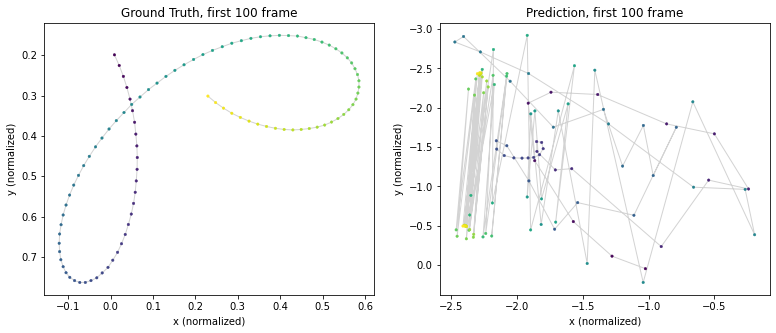

In [202]:
plot_comparison(Xgen,Xgen_test,100,4,5)